In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Clean stuff

In [3]:
!rm -rf /kaggle/working/*

# Import libraries and Customize Parameters

In [4]:
# Pip install method (recommended)
%pip install ultralytics
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.3/887.3 kB 20.6 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Importing the required libraries
from ultralytics import YOLO
import squarify
import matplotlib.pyplot as plt
import cv2
import os
import random
import pandas as pd
import matplotlib.image as mpimg
import seaborn as sns
import torch

sns.set_style('darkgrid')

%matplotlib inline

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [10]:
# Check if PyTorch is using the GPU
print("Is CUDA available? ", torch.cuda.is_available())
print("Device name: ", torch.cuda.get_device_name(0))
# Set the device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device is on: {device}')

Is CUDA available?  True
Device name:  Tesla P100-PCIE-16GB
Device is on: cuda


# Visualize simple images with annotations

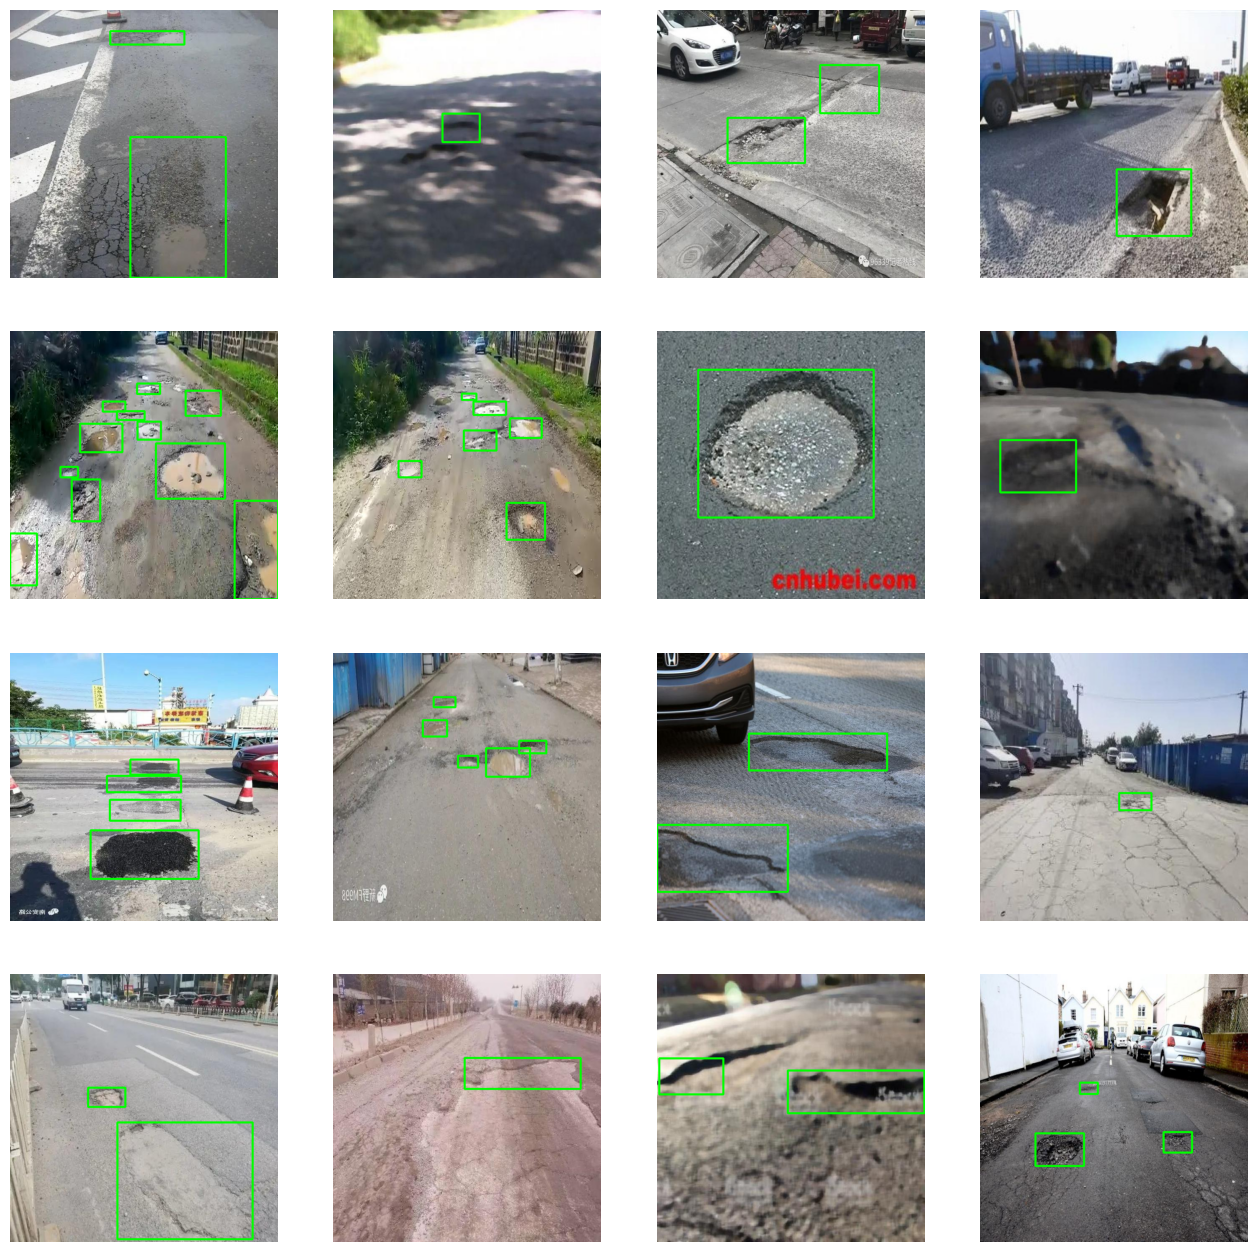

In [11]:
# Define the paths to the images and labels directories
train_images = "/kaggle/input/pothole-reduced-dataset/reduced_dataset/train/images"
train_labels = "/kaggle/input/pothole-reduced-dataset/reduced_dataset/train/labels"

test_images = "/kaggle/input/pothole-reduced-dataset/reduced_dataset/test/images"
test_labels = "/kaggle/input/pothole-reduced-dataset/reduced_dataset/test/images"

val_images = "/kaggle/input/pothole-reduced-dataset/reduced_dataset/valid/images"
val_labels = "/kaggle/input/pothole-reduced-dataset/reduced_dataset/valid/labels"

# Get a list of all the image files in the training images directory
image_files = os.listdir(train_images)

# Choose 16 random image files from the list
random_images = random.sample(image_files, 16)

# Set up the plot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Loop over the random images and plot the object detections
for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4
    
    # Load the image
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    # Load the labels for this image
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    # Loop over the labels and plot the object detections
    # Loop over the labels and plot the object detections
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)


    # Show the image with the object detections
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()

# Show image metadata

In [12]:
# Load an image using OpenCV
image = cv2.imread("/kaggle/input/pothole-reduced-dataset/reduced_dataset/test/images/0004_jpg.rf.f92ab952cd8544f887caf35fcccbcd10.jpg")

# Get the size of the image
height, width, channels = image.shape
print(f"The image has dimensions {width}x{height} and {channels} channels.")

The image has dimensions 640x640 and 3 channels.


# Model Training

In [13]:
# Loading a pretrained model
model = YOLO('yolo11n.pt')

# free up GPU memory
torch.cuda.empty_cache()

# Training the model
model.train(data = '/kaggle/input/pothole-reduced-dataset/reduced_dataset/data.yaml',
            epochs = 20,
            imgsz = (height, width, channels),
            seed = 42,
            batch = 8,
            workers = 4,
            optimizer = "Adam")

100%|██████████| 5.35M/5.35M [00:00<00:00, 98.2MB/s]

Ultralytics 8.3.36 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/input/pothole-reduced-dataset/reduced_dataset/data.yaml, epochs=20, time=None, patience=100, batch=8, imgsz=(640, 640, 3), save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torc

100%|██████████| 755k/755k [00:00<00:00, 27.1MB/s]
2024-11-23 17:04:41,839	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-23 17:04:42,532	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/input/pothole-reduced-dataset/reduced_dataset/train/labels... 2400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2400/2400 [00:07<00:00, 320.98it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/pothole-reduced-dataset/reduced_dataset/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/pothole-reduced-dataset/reduced_dataset/valid/labels... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:01<00:00, 257.53it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/pothole-reduced-dataset/reduced_dataset/valid is not writeable, cache not saved.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.46G      2.138      2.473      2.003         49        640: 100%|██████████| 300/300 [00:44<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.93it/s]

                   all        300        936      0.095      0.106     0.0363     0.0109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      1.44G       2.16      2.401      2.082         38        640: 100%|██████████| 300/300 [00:40<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.57it/s]

                   all        300        936      0.316      0.281      0.223      0.085



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.44G      2.081      2.262      2.013         46        640: 100%|██████████| 300/300 [00:40<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.85it/s]


                   all        300        936      0.278      0.268       0.19     0.0699

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.44G      2.018      2.167      1.944         44        640: 100%|██████████| 300/300 [00:39<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.46it/s]

                   all        300        936      0.422      0.315      0.295       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.44G      1.971      2.078      1.893         37        640: 100%|██████████| 300/300 [00:39<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.75it/s]

                   all        300        936       0.49      0.401      0.398      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.44G      1.904       1.98      1.854         30        640: 100%|██████████| 300/300 [00:39<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.09it/s]

                   all        300        936      0.505      0.366      0.367      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.44G      1.924      1.964      1.859         39        640: 100%|██████████| 300/300 [00:39<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.58it/s]

                   all        300        936       0.54      0.455      0.466      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.44G      1.859      1.879      1.809         40        640: 100%|██████████| 300/300 [00:39<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.36it/s]


                   all        300        936      0.622      0.435      0.482      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.44G      1.852      1.849      1.799         33        640: 100%|██████████| 300/300 [00:40<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.27it/s]

                   all        300        936      0.607      0.425      0.469      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.44G      1.814      1.799      1.785         27        640: 100%|██████████| 300/300 [00:39<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.40it/s]

                   all        300        936      0.616      0.451      0.488      0.233


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.44G       1.82      1.764      1.826         20        640: 100%|██████████| 300/300 [00:39<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.04it/s]


                   all        300        936      0.581      0.428      0.468      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.44G      1.823      1.712       1.82         34        640: 100%|██████████| 300/300 [00:39<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.64it/s]

                   all        300        936      0.664      0.457      0.523      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.44G       1.76      1.604      1.774         12        640: 100%|██████████| 300/300 [00:39<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.19it/s]

                   all        300        936      0.582      0.489      0.513      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      1.44G       1.75      1.583      1.765         32        640: 100%|██████████| 300/300 [00:38<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.25it/s]

                   all        300        936      0.632      0.487      0.534      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      1.44G      1.728      1.544      1.746         26        640: 100%|██████████| 300/300 [00:39<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.48it/s]

                   all        300        936      0.687      0.526      0.591      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.44G      1.703      1.512      1.713         22        640: 100%|██████████| 300/300 [00:39<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.78it/s]

                   all        300        936      0.667      0.517      0.579      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.44G      1.672      1.467      1.702         30        640: 100%|██████████| 300/300 [00:38<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.46it/s]

                   all        300        936      0.632      0.532      0.588      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.44G      1.658      1.418       1.67         18        640: 100%|██████████| 300/300 [00:38<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.67it/s]

                   all        300        936      0.713      0.542      0.619      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      1.44G      1.625      1.368      1.654         20        640: 100%|██████████| 300/300 [00:38<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.80it/s]

                   all        300        936       0.67      0.593      0.633      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.44G        1.6      1.335      1.642         16        640: 100%|██████████| 300/300 [00:39<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.05it/s]

                   all        300        936      0.701      0.573      0.645      0.352



20 epochs completed in 0.237 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.36 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.67it/s]


                   all        300        936      0.701      0.572      0.645      0.352
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c5aac38d150>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Model Performance

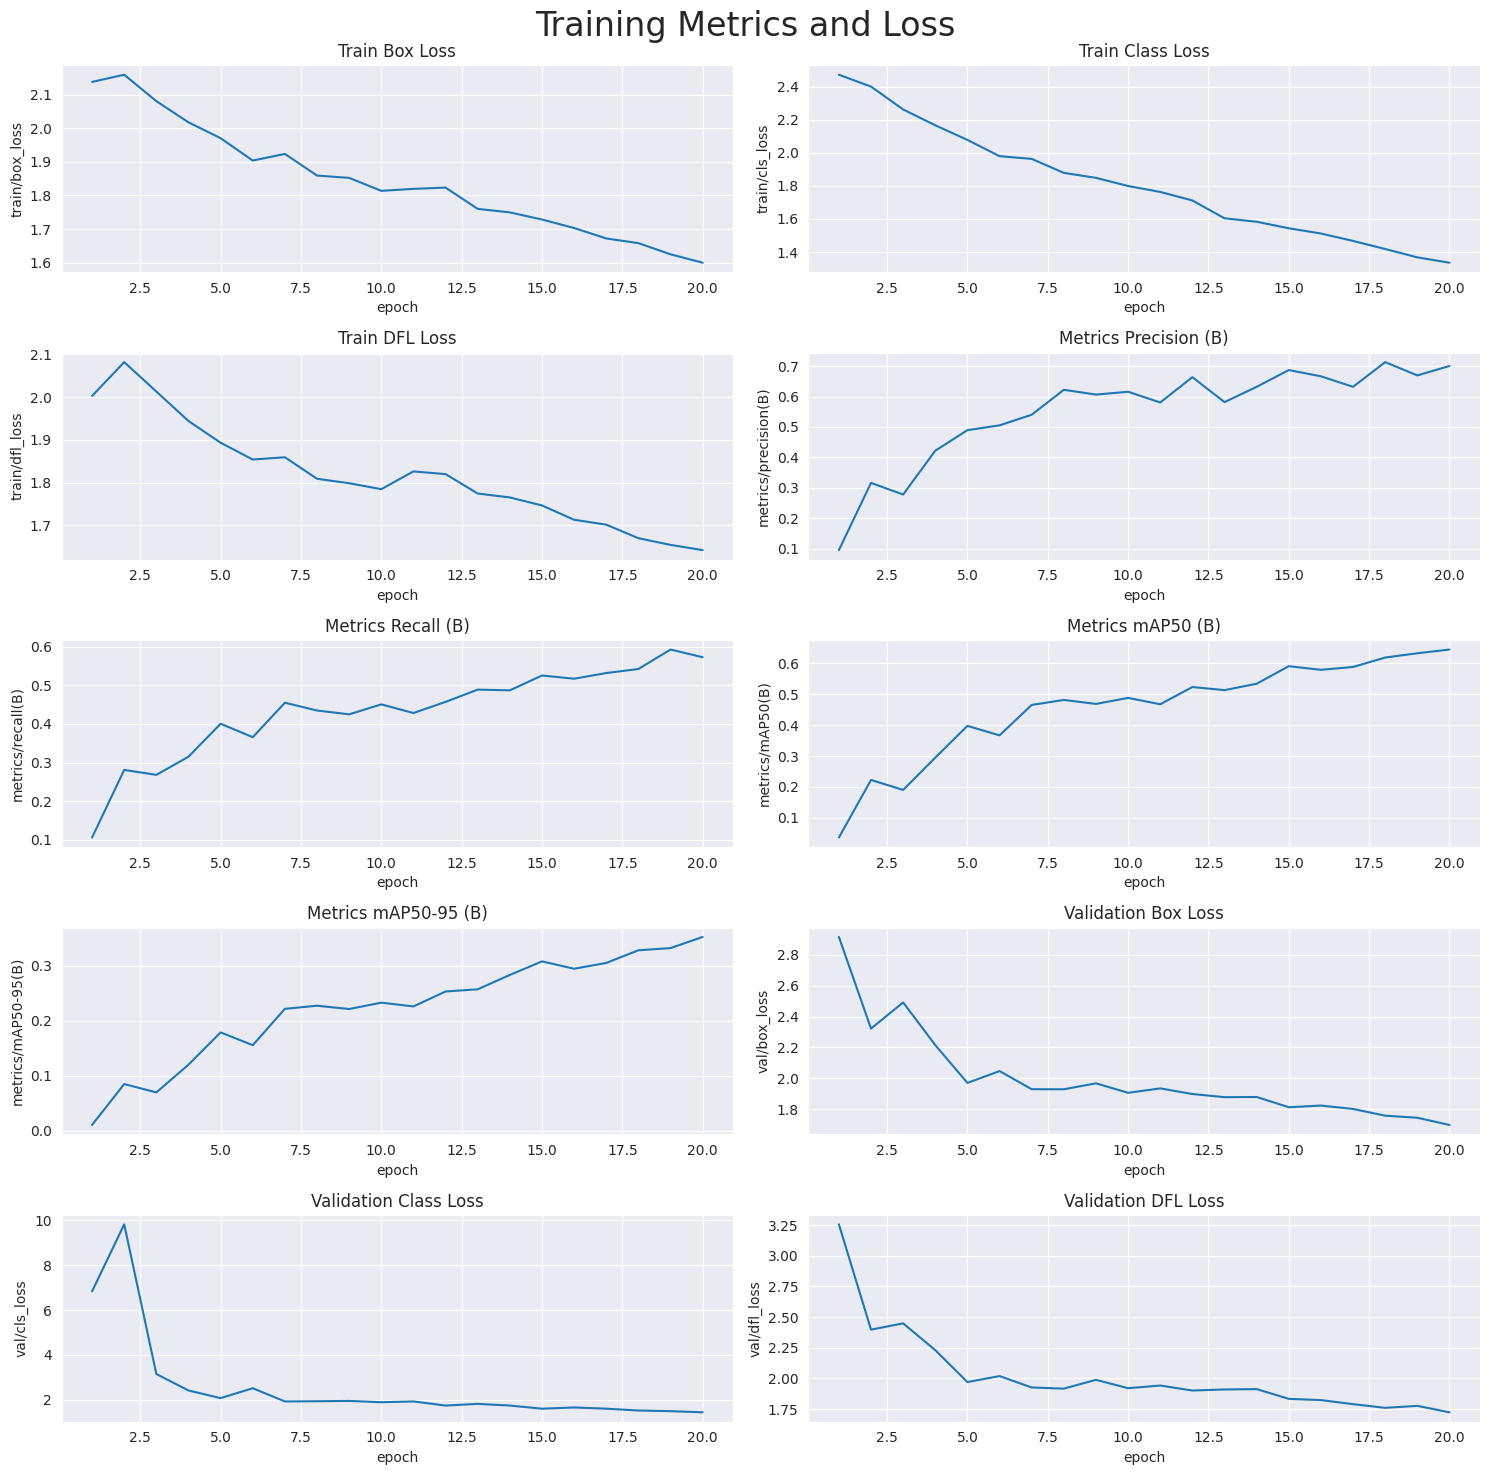

In [14]:
%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('/kaggle/working/runs/detect/train/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

# Model Evaluation

In [15]:
%matplotlib inline
# Loading the best performing model
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# Evaluating the model on the test dataset
metrics = model.val(conf = 0.25, split = 'test')

Ultralytics 8.3.36 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/input/pothole-reduced-dataset/reduced_dataset/test/labels... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<00:00, 310.77it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/pothole-reduced-dataset/reduced_dataset/test is not writeable, cache not saved.



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.41it/s]


                   all        300        844       0.73      0.639      0.725      0.414
Speed: 0.2ms preprocess, 3.3ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val


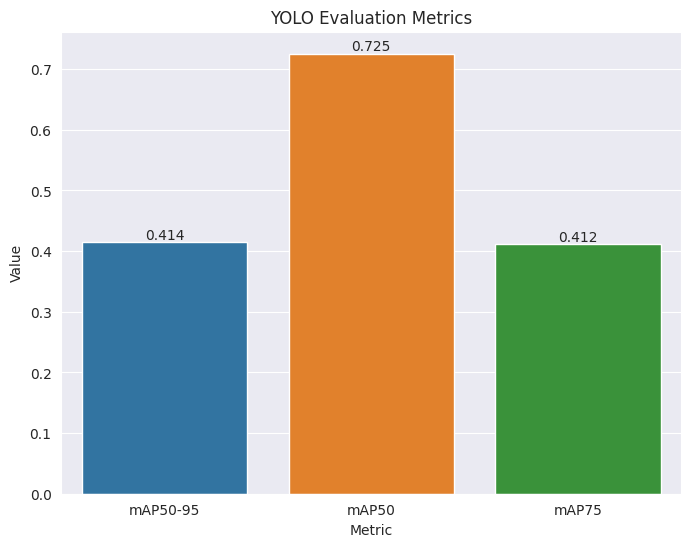

In [16]:
%matplotlib inline
# Create the barplot
ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])

# Set the title and axis labels
ax.set_title('YOLO Evaluation Metrics')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')

# Set the figure size
fig = plt.gcf()
fig.set_size_inches(8, 6)

# Add the values on top of the bars
for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    
# Show the plot
plt.show()


## Confusion Matrix

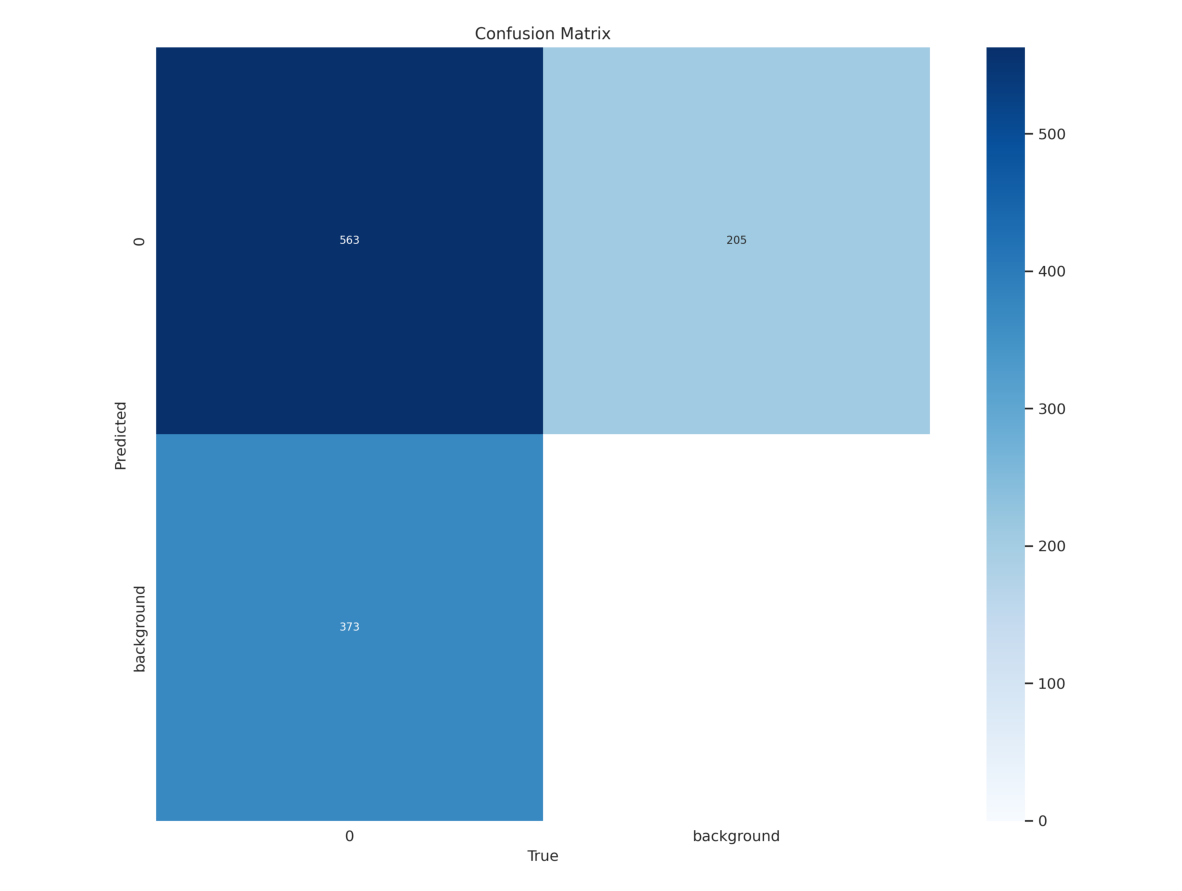

In [17]:
%matplotlib inline
# Reading the confusion matrix image file
img = mpimg.imread('/kaggle/working/runs/detect/train/confusion_matrix.png')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (15, 15))

ax.imshow(img)
ax.axis('off');

# Making Predictions on Test Images

In [18]:
# Function to perform ship detections
def pothole_detect(img_path):
    
    # Read the image
    img = cv2.imread(img_path)

    # Pass the image through the detection model and get the result
    detect_result = model(img)

    # Plot the detections
    detect_img = detect_result[0].plot()
    
    # Convert the image to RGB format
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)
    
    return detect_img


0: 640x640 2 0s, 9.8ms
Speed: 2.2ms preprocess, 9.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 0s, 7.6ms
Speed: 3.5ms preprocess, 7.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 0s, 8.1ms
Speed: 2.0ms preprocess, 8.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 0s, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 0s, 8.1ms
Speed: 2.0ms preprocess, 8.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 0s, 7.7ms
Speed: 2.1ms preprocess, 7.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 0s, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 0s, 7.9ms
Speed: 2.1ms preprocess, 7.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 0s, 8.0ms
Speed: 2.5ms pre

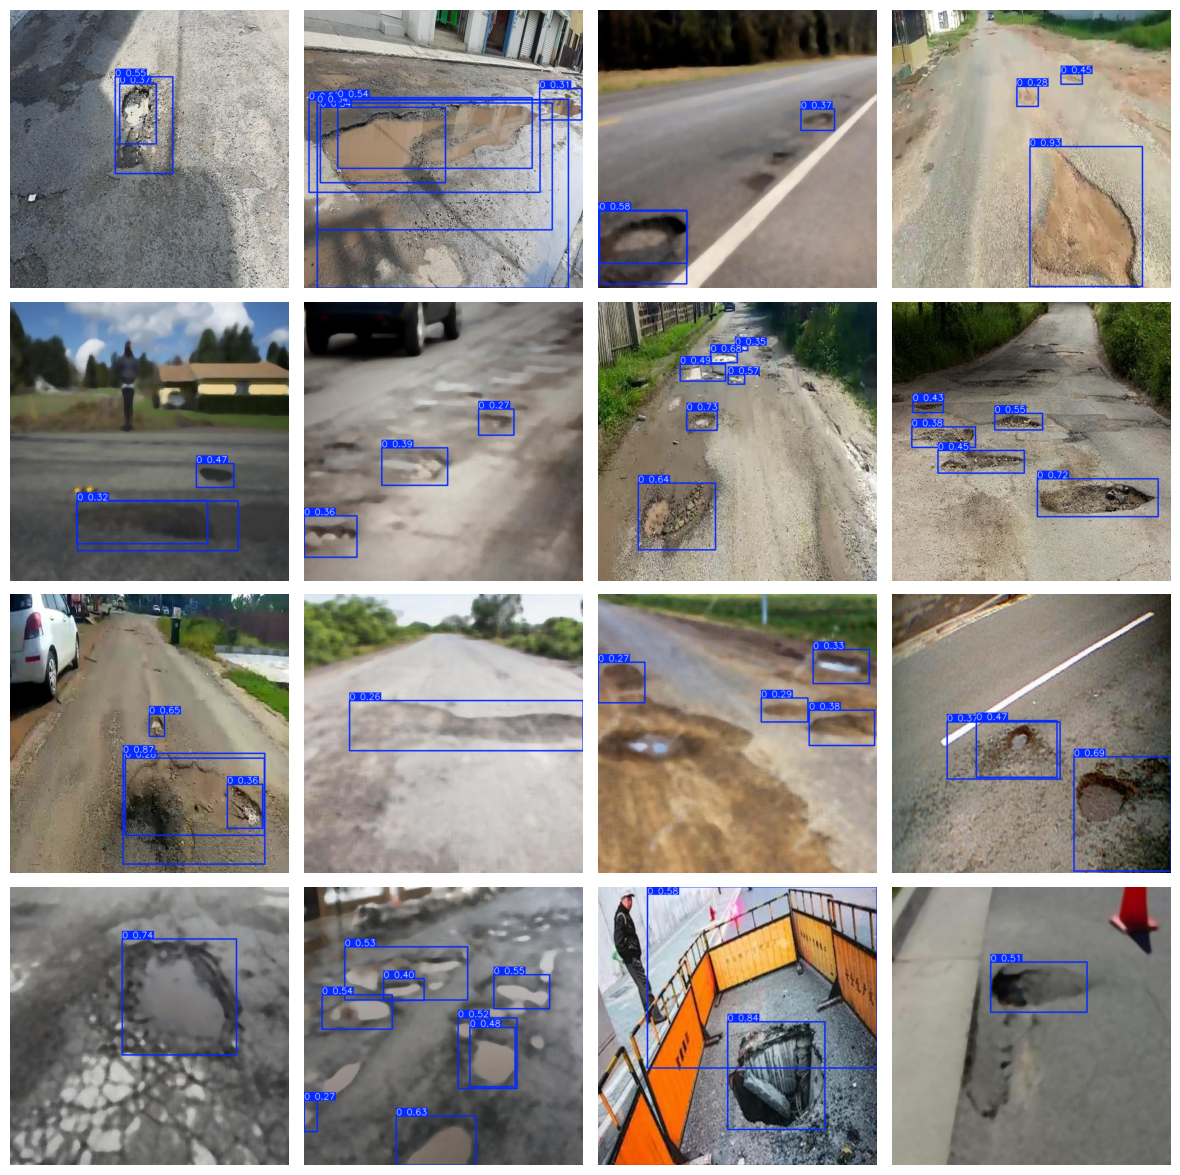

In [20]:
import random

# Define the directory where the custom images are stored
custom_image_dir = '/kaggle/input/pothole-reduced-dataset/reduced_dataset/test/images'

# Get the list of image files in the directory
image_files = os.listdir(custom_image_dir)

# Select 16 random images from the list
selected_images = random.sample(image_files, 16)

# Create a figure with subplots for each image
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

# Iterate over the selected images and plot each one
for i, img_file in enumerate(selected_images):
    
    # Compute the row and column index of the current subplot
    row_idx = i // 4
    col_idx = i % 4
    
    # Load the current image and run object detection
    img_path = os.path.join(custom_image_dir, img_file)
    detect_img = pothole_detect(img_path)
    
    # Plot the current image on the appropriate subplot
    axes[row_idx, col_idx].imshow(detect_img)
    axes[row_idx, col_idx].axis('off')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# Download train results and model

In [23]:
# zip the test results folder
!zip -r yolo_training_results.zip /kaggle/working/runs

  adding: kaggle/working/runs/ (stored 0%)
  adding: kaggle/working/runs/detect/ (stored 0%)
  adding: kaggle/working/runs/detect/val/ (stored 0%)
  adding: kaggle/working/runs/detect/val/F1_curve.png (deflated 19%)
  adding: kaggle/working/runs/detect/val/PR_curve.png (deflated 16%)
  adding: kaggle/working/runs/detect/val/val_batch2_pred.jpg (deflated 6%)
  adding: kaggle/working/runs/detect/val/confusion_matrix.png (deflated 40%)
  adding: kaggle/working/runs/detect/val/val_batch2_labels.jpg (deflated 6%)
  adding: kaggle/working/runs/detect/val/val_batch1_labels.jpg (deflated 9%)
  adding: kaggle/working/runs/detect/val/val_batch0_pred.jpg (deflated 7%)
  adding: kaggle/working/runs/detect/val/val_batch1_pred.jpg (deflated 9%)
  adding: kaggle/working/runs/detect/val/R_curve.png (deflated 18%)
  adding: kaggle/working/runs/detect/val/confusion_matrix_normalized.png (deflated 40%)
  adding: kaggle/working/runs/detect/val/P_curve.png (deflated 19%)
  adding: kaggle/working/runs/detec

In [24]:
!mkdir /kaggle/output/
!mv yolo_training_results.zip /kaggle/output/

mkdir: cannot create directory '/kaggle/output/': File exists
